# Tutorial: Building a Chat Application with Function Calling

- **Level**: Advanced
- **Time to complete**: 20 minutes
- **Components Used**: [InMemoryDocumentStore](https://docs.haystack.deepset.ai/v2.0/docs/inmemorydocumentstore), [SentenceTransformersDocumentEmbedder](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformersdocumentembedder), [SentenceTransformersTextEmbedder](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformerstextembedder), [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/v2.0/docs/inmemoryembeddingretriever), [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder), [OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator), [OpenAIChatGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaichatgenerator)
- **Prerequisites**: You must have an [OpenAI API Key](https://platform.openai.com/api-keys) and be familiar with [creating pipelines](https://docs.haystack.deepset.ai/v2.0/docs/creating-pipelines)
- **Goal**: After completing this tutorial, you will have learned how to build chat applications that demonstrate agent-like behavior using OpenAI's function calling feature.

> This tutorial uses Haystack 2.0. To learn more, read the [Haystack 2.0 announcement](https://haystack.deepset.ai/blog/haystack-2-release) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/docs/intro).


## Overview



📚 Useful Sources:
* [OpenAIChatGenerator Docs](https://docs.haystack.deepset.ai/v2.0/docs/openaichatgenerator)
* [OpenAIChatGenerator API Reference](https://docs.haystack.deepset.ai/v2.0/reference/generator-api#openaichatgenerator)
* [🧑‍🍳 Cookbook: Function Calling with OpenAIChatGenerator](https://github.com/deepset-ai/haystack-cookbook/blob/main/notebooks/function_calling_with_OpenAIChatGenerator.ipynb)

[OpenAI's function calling](https://platform.openai.com/docs/guides/function-calling) connects large language models to external tools. By providing a `tools` list with functions and their specifications to the OpenAI API calls, you can easily build chat assistants that can answer questions by calling external APIs or extract structured information from text.

In this tutorial, you'll learn how to convert your Haystack pipeline into a function-calling tool and how to implement applications using OpenAI's Chat Completion API through `OpenAIChatGenerator` for agent-like behavior.

## Setting up the Development Environment

Install Haystack 2.0 and [sentence-transformers](https://pypi.org/project/sentence-transformers/) using pip:

In [ ]:
%%bash

pip install haystack-ai
pip install "sentence-transformers>=2.2.0"

### Enable Telemetry

Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/v2.0/docs/telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(40)

Save your OpenAI API key as an environment variable:

In [2]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OPENAI_API_KEY: ")

## Learning about the OpenAIChatGenerator

[OpenAIChatGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaichatgenerator) is a component that supports the function calling feature of OpenAI through Chat Completion API. In contrary to `OpenAIGenerator`, the way to communicate with `OpenAIChatGenerator` is through [`ChatMessage`](https://docs.haystack.deepset.ai/v2.0/docs/data-classes#chatmessage) list. Read more about the difference between them in [Generators vs Chat Generators](https://docs.haystack.deepset.ai/v2.0/docs/generators-vs-chat-generators).


To start working with the `OpenAIChatGenerator`, create a `ChatMessage` object with "SYSTEM" role using `ChatMessage.from_system()` and another `ChatMessage` with "USER" role using `ChatMessage.from_user()`. Then, pass this messages list to `OpenAIChatGenerator` and run:

In [4]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

messages = [
    ChatMessage.from_system("Always respond in German even if some input data is in other languages."),
    ChatMessage.from_user("What's Natural Language Processing? Be brief."),
]

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo")
chat_generator.run(messages=messages)

{'replies': [ChatMessage(content='Natürliche Sprachverarbeitung (NLP) ist ein Bereich der künstlichen Intelligenz, der sich mit der Wechselwirkung zwischen Menschensprache und Maschinen befasst. Es zielt darauf ab, Computern das Verstehen, Interpretieren und Generieren menschlicher Sprache zu ermöglichen.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 74, 'prompt_tokens': 34, 'total_tokens': 108}})]}

### Basic Streaming

`OpenAIChatGenerator` supports streaming, provide a `streaming_callback` function and run the `chat_generator` again to see the difference.

In [5]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages)

Natural Language Processing (NLP) ist ein Bereich der künstlichen Intelligenz, der sich mit dem Verstehen und der Verarbeitung von menschlicher Sprache durch Computer befasst.

## Creating a Function Calling Tool from a Haystack Pipeline

To use the function calling of OpenAI, you need to introduce `tools` to your `OpenAIChatGenerator` using its `generation_kwargs` param.

For this example, you'll use a Haystack RAG pipeline as one of your tools. Therefore, you need to index documents to a document store and then build a RAG pipeline on top of it.

### Index Documents with a Pipeline

Create a pipeline to store the small example dataset in the [InMemoryDocumentStore](https://docs.haystack.deepset.ai/v2.0/docs/inmemorydocumentstore) with their embeddings. You will use [SentenceTransformersDocumentEmbedder](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformersdocumentembedder) to generate embeddings for your Documents and write them to the document store with the [DocumentWriter](https://docs.haystack.deepset.ai/v2.0/docs/documentwriter).

After adding these components to your pipeline, connect them and run the pipeline.

> If you'd like to learn about preprocessing files before you index them to your document store, follow the [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline) tutorial.

In [6]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

documents = [
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome."),
    Document(content="My name is Marta and I live in Madrid."),
    Document(content="My name is Harry and I live in London."),
]

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="doc_writer")

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'doc_writer': {'documents_written': 5}}

### Build a RAG Pipeline

Build a basic retrieval augmented generative pipeline with [SentenceTransformersTextEmbedder](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformerstextembedder), [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/v2.0/docs/inmemoryembeddingretriever), [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder) and [OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator).

> For a step-by-step guide to create a RAG pipeline with Haystack, follow the [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) tutorial.

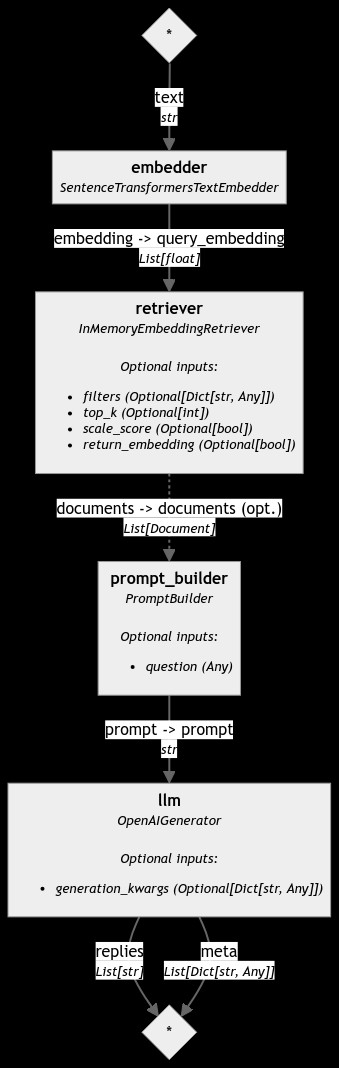

In [7]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""
rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipe.add_component("llm", OpenAIGenerator(model="gpt-3.5-turbo"))

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder", "llm")

### Run the Pipeline
Test this pipeline with a query and see if it works as expected before you start using it as a function calling tool.

In [8]:
query = "Where does Mark live?"
rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'replies': ['Berlin'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 1,
     'prompt_tokens': 86,
     'total_tokens': 87}}]}}

### Convert the Haystack Pipeline into a Tool

Wrap the `rag_pipe.run` call with a function called `rag_pipeline_func`. This `rag_pipeline_func` function will accept a `query` and return the response coming from the LLM of the RAG pipeline you built before. You will then introduce this function as a tool to your `OpenAIChatGenerator`.

In [9]:
def rag_pipeline_func(query: str):
    result = rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

    return {"reply": result["llm"]["replies"][0]}

## Creating Your `tools` List

In addition to the `rag_pipeline_func` tool, create a new tool called `get_current_weather` to be used to get weather information of cities. For demonstration purposes, you can use hardcoded data in this function.

In [10]:
WEATHER_INFO = {
    "Berlin": {"weather": "mostly sunny", "temperature": 7, "unit": "celsius"},
    "Paris": {"weather": "mostly cloudy", "temperature": 8, "unit": "celsius"},
    "Rome": {"weather": "sunny", "temperature": 14, "unit": "celsius"},
    "Madrid": {"weather": "sunny", "temperature": 10, "unit": "celsius"},
    "London": {"weather": "cloudy", "temperature": 9, "unit": "celsius"},
}


def get_current_weather(location: str):
    if location in WEATHER_INFO:
        return WEATHER_INFO[location]

    # fallback data
    else:
        return {"weather": "sunny", "temperature": 21.8, "unit": "fahrenheit"}

Now, add function specifications for `rag_pipeline_func` and `get_current_weather` to your `tools` list by following [OpenAI's tool schema](https://platform.openai.com/docs/api-reference/chat/create#chat-create-tools). Provide detailed descriptions about `rag_pipeline_func` and `query` so that OpenAI can generate the adaquate arguments for this tool.

In [11]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "rag_pipeline_func",
            "description": "Get information about where people live",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                    }
                },
                "required": ["query"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {"type": "string", "description": "The city and state, e.g. San Francisco, CA"}
                },
                "required": ["location"],
            },
        },
    },
]

## Running OpenAIChatGenerator with Tools

To use the function calling feature, you need to pass the list of tools in the `run()` method of OpenAIChatGenerator as `generation_kwargs`.

Instruct the model to use provided tools with a system message and then provide a query that requires a function call as a user message:

In [12]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

messages = [
    ChatMessage.from_system(
        "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."
    ),
    ChatMessage.from_user("Can you tell me where Mark lives?"),
]

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

As a response, you'll get a `ChatMessage` with information about the tool name and arguments in JSON format:

```python
{'replies': [
    ChatMessage(
        content='[{"index": 0, "id": "call_3VnT0XQH0ye41g3Ip5CRz4ri", "function": {"arguments": "{\\"query\\":\\"Where does Mark live?\\"}", "name": "rag_pipeline_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, 
        name=None, 
        meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {}}
        )
    ]
}
```

You can then parse the message content string into JSON and call the corresponding function with the provided arguments.

In [14]:
import json

## Parse function calling information
function_call = json.loads(response["replies"][0].content)[0]
function_name = function_call["function"]["name"]
function_args = json.loads(function_call["function"]["arguments"])
print("Function Name:", function_name)
print("Function Arguments:", function_args)

## Find the correspoding function and call it with the given arguments
available_functions = {"rag_pipeline_func": rag_pipeline_func, "get_current_weather": get_current_weather}
function_to_call = available_functions[function_name]
function_response = function_to_call(**function_args)
print("Function Response:", function_response)

Function Name: rag_pipeline_func
Function Arguments: {'query': 'Where does Mark live?'}


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Function Response: {'reply': 'Mark lives in Berlin.'}


As the last step, run the OpenAIChatGenerator again by appending the function response to the `messages` list as a new message with `ChatMessage.from_function()` and let the model summarize the results.

In [15]:
from haystack.dataclasses import ChatMessage

function_message = ChatMessage.from_function(content=json.dumps(function_response), name=function_name)
messages.append(function_message)

response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

Mark lives in Berlin.

## Building the Chat Application

As you notice above, OpenAI Chat Completions API does not call the function; instead, the model generates JSON that you can use to call the function in your code. That's why, to build an end-to-end chat application, you need to check if the OpenAI response is a `tool_calls` for every message. If so, you need to call the corresponding function with the provided arguments and send the function response back to OpenAI. Otherwise, append both user and messages to the `messages` list to have a regular conversation with the model. 

Run the code cell below and use the input box to interact with the chat application that has access to two tools you've created above.  

Example queries you can try:
* "***What is the capital of Sweden?***": A basic query without any function calls
* "***Can you tell me where Giorgio lives?***": A basic query with one function call
* "***What's the weather like in Berlin?***", "***Is it sunny there?***": To see the messages are being recorded and sent
* "***What's the weather like where Jean lives?***": To force two function calls
* "***What's the weather like today?***": To force OpenAI to ask more clarification

> Keep in mind that OpenAI models can sometimes hallucinate answers or tools and might not work as expected.

In [24]:
import json

from haystack.dataclasses import ChatMessage, ChatRole
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", streaming_callback=print_streaming_chunk)
response = None
messages = [
    ChatMessage.from_system(
        "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."
    )
]

while True:
    # if OpenAI response is a tool call
    if response and response["replies"][0].meta["finish_reason"] == "tool_calls":
        function_calls = json.loads(response["replies"][0].content)

        for function_call in function_calls:
            ## Parse function calling information
            function_name = function_call["function"]["name"]
            function_args = json.loads(function_call["function"]["arguments"])

            ## Find the correspoding function and call it with the given arguments
            function_to_call = available_functions[function_name]
            function_response = function_to_call(**function_args)

            ## Append function response to the messages list using `ChatMessage.from_function`
            messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))

    # Regular Conversation
    else:
        # Append assistant messages to the messages list
        if not messages[-1].is_from(ChatRole.SYSTEM):
            messages.append(response["replies"][0])

        user_input = input("ENTER YOUR MESSAGE 👇 INFO: Type 'exit' or 'quit' to stop\n")
        if user_input.lower() == "exit" or user_input.lower() == "quit":
            break
        else:
            messages.append(ChatMessage.from_user(user_input))

    response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})

ENTER YOUR MESSAGE 👇 INFO: Type 'exit' or 'quit' to stop
Can you tell me where Giorgio lives?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Giorgio lives in Rome.ENTER YOUR MESSAGE 👇 INFO: Type 'exit' or 'quit' to stop
What's the weather like there?
The weather in Rome is sunny with a temperature of 14°C.ENTER YOUR MESSAGE 👇 INFO: Type 'exit' or 'quit' to stop
exit


## What's next

🎉 Congratulations! You've learned how to build chat applications that demonstrate agent-like behavior using OpenAI function calling and Haystack Pipelines.

If you liked this tutorial, there's more to learn about Haystack 2.0:
- [Serializing LLM Pipelines](https://haystack.deepset.ai/tutorials/29_serializing_pipelines)
- [Model-Based Evaluation of RAG Pipelines](https://haystack.deepset.ai/tutorials/35_model_based_evaluation_of_rag_pipelines)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates?utm_campaign=developer-relations&utm_source=tutorial&utm_medium=function-calling) or [join Haystack discord community](https://discord.gg/haystack).

Thanks for reading!